In [63]:
import pandas as pd
import os

## Output analysis and evaluation

Metrics to calculate:

- **Label flip score:** the percentage of the time the counterfactual flips the output of the classifier.
    - You can calculate this easily using the found flip column.
- **Similarity score:** 1 - the normalized Levenshtein distance between the original and counterfactual text.
- **Perplexity:** the perplexity score of the generated counterfactual (lower is better)
    - Calculate the average perplexity for the original and counterfactual text.

In [64]:
%pwd

'/Users/smcaleese/Documents/masters-thesis-code/analysis'

Best possible:
- counterfactual_perplexity: 259.4843315696716, original_perplexity: 259.4843315696716
- perplexity_score: ~1.0

Polyjuice:
- counterfactual_perplexity: 330.9339884185791, original_perplexity: 259.4843315696716
- perplexity score: ~0.7

CLOSS:
- counterfactual_perplexity: 588.1533823394775, original_perplexity: 259.4843315696716
- perplexity score: ~0.4

Worst possible score:
- counterfactual_perplexity: 1500, original_perplexity: 259.4843315696716
- perplexity score: ~0.1


In [77]:
# def calculate_perplexity_score(counterfactual_perplexity, original_perplexity):
#     print(f"Counterfactual perplexity: {counterfactual_perplexity}, Original perplexity: {original_perplexity}")
#     ratio = counterfactual_perplexity / original_perplexity
#     score = 1 / ratio
#     return score

def calculate_perplexity_score(counterfactual_perplexity, original_perplexity):
    ratio = counterfactual_perplexity / original_perplexity
    # midpoint = 1.5
    midpoint = 2
    steepness = 3
    score = 1 / (1 + np.exp(steepness * (ratio - midpoint)))
    print(f"Counterfactual perplexity: {counterfactual_perplexity}, Original perplexity: {original_perplexity}, Ratio: {ratio}, score: {score}")
    return score

def calculate_metrics(df, precision=3):
    """Calculate and round metrics from the given DataFrame."""
    metrics = {
        "label_flip_score": df["found_flip"].mean(),
        "sparsity_score": df["levenshtein_similarity_score"].mean(),
        "perplexity_score": calculate_perplexity_score(df["counterfactual_perplexity"].mean(), df["original_perplexity"].mean())
    }
    return {key: round(value, precision) for key, value in metrics.items()}

def min_max_normalize(arr):
    """Perform min-max normalization on the given array."""
    min_val, max_val = min(arr), max(arr)
    return [(x - min_val) / (max_val - min_val) for x in arr]

def process_csv_files(directory):
    """Process all CSV files in the given directory and return collected data."""
    data = {
        "method_name": [],
        "label_flip_score": [],
        "sparsity_score": [],
        "perplexity_score": []
    }

    for file in os.listdir(directory):
        if file.endswith(".csv"):
            method_name = file.split("-")[0]
            data["method_name"].append(method_name)
            print(f"Processing method: {method_name}")
            
            df = pd.read_csv(os.path.join(directory, file))
            metrics = calculate_metrics(df)
            for key in metrics:
                data[key].append(metrics[key])

    return data


In [78]:
output_dir = "../output"

# Collect data from the CSV files
data = process_csv_files(output_dir)

# Display the final dataframe
df = pd.DataFrame(data).set_index("method_name")
df.head()

Processing method: closs
Counterfactual perplexity: 725.602497297287, Original perplexity: 383.8430952987671, Ratio: 1.8903622500556092, score: 0.5814949303150425
Processing method: polyjuice
Counterfactual perplexity: 361.33941942882535, Original perplexity: 383.8430952987671, Ratio: 0.9413727219648804, score: 0.9599165119626827
Processing method: hotflip
Counterfactual perplexity: 563.7330639381408, Original perplexity: 383.8430952987671, Ratio: 1.4686549552216253, score: 0.831183061053485
Processing method: fizle
Counterfactual perplexity: 150.136448802948, Original perplexity: 259.4843315696716, Ratio: 0.5785954315420248, score: 0.9861321027493066


,label_flip_score,sparsity_score,perplexity_score
method_name,,,
closs,0.781,0.892,0.581
polyjuice,0.230,0.732,0.960
hotflip,0.632,0.938,0.831
fizle,0.860,0.793,0.986


In [79]:
df = df.rename(index={"fizle": "fizle (GPT-4-turbo)"})

## Create bar chart

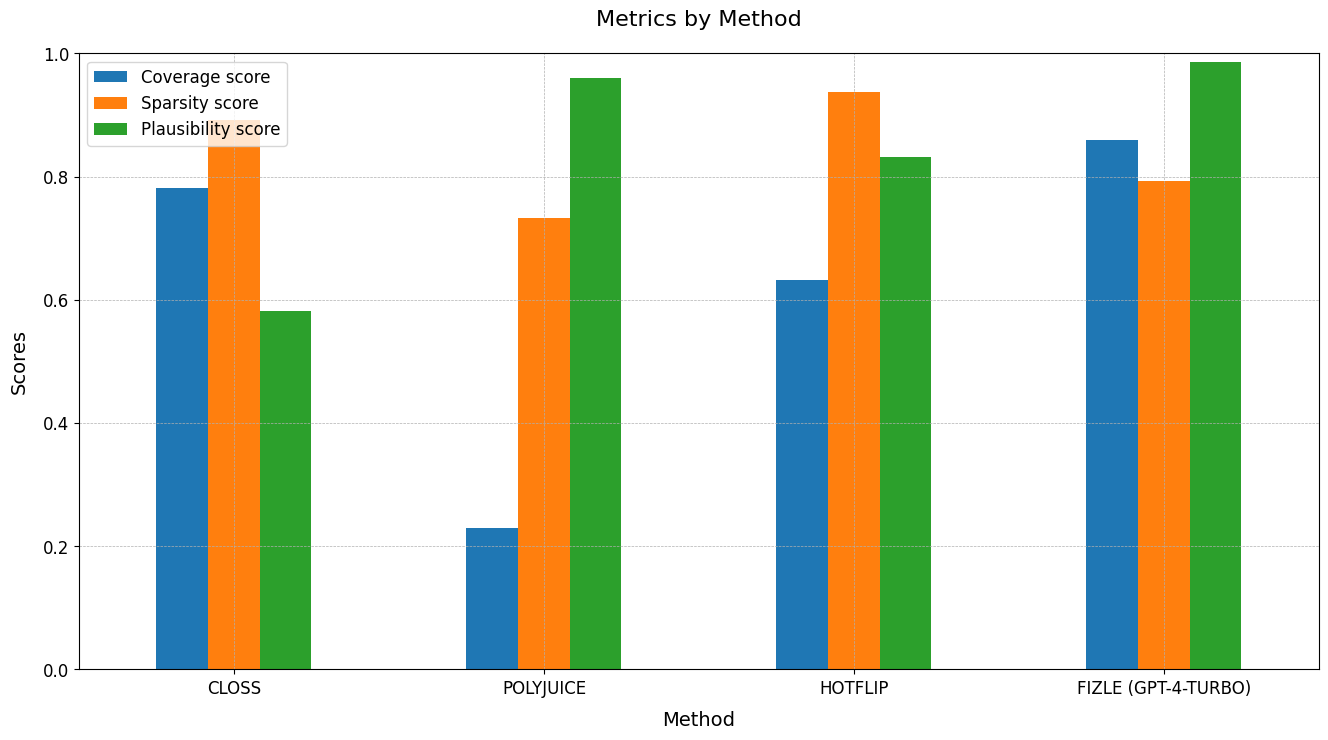

In [80]:
import matplotlib.pyplot as plt

# plt.style.use('ggplot')
plt.style.use('default')

ax = df.plot.bar(figsize=(16, 8), fontsize=12)
ax.set_title('Metrics by Method', fontsize=16, pad=20)

ax.set_xlabel('Method', fontsize=14, labelpad=10)
ax.set_xticklabels(df.index.str.upper(), rotation=0, ha='center', fontsize=12)

ax.set_ylabel('Scores', fontsize=14, labelpad=10)
ax.set_ylim([0, 1])

ax.legend(labels=["Coverage score", "Sparsity score", "Plausibility score"], fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig("results-3.png", dpi=300)

### Thoughts

- FIZLE seems to prioritize plausibility over sparsity
- CLOSS prioritizes sparsity over plausibility
- CLOSS and HOTFLIP focus on maximizing coverage while maximizing sparsity

Question: which metric do users care most about: plausibility, sparsity, or coverage when explaining a model?

You could find out using an RLHF-like method where users compare the usefulness of explanations and then you can calculate the three metrics and see which one is most correlated with real-world usefulness.

In [ ]:
# coverage vs sparsity
# coverage vs plausibility


In [6]:
import pandas as pd
import plotly.graph_objects as go

# Load the data from the CSV file
df = pd.read_csv('data.csv')

# Ensure the method_name column is used as the index
df.set_index('method_name', inplace=True)

# Create a grouped bar chart using plotly
fig = go.Figure()

# Add bars for each metric
fig.add_trace(go.Bar(
    x=df.index,
    y=df['label_flip_score'],
    name='Label Flip Score',
    marker_color='#1f77b4'
))

fig.add_trace(go.Bar(
    x=df.index,
    y=df['mean_fraction_tokens_same'],
    name='Mean Fraction Tokens Same',
    marker_color='#ff7f0e'
))

fig.add_trace(go.Bar(
    x=df.index,
    y=df['mean_inverted_counterfactual_perplexity'],
    name='Mean Inverted Counterfactual Perplexity',
    marker_color='#2ca02c'
))

# Update layout for better appearance
fig.update_layout(
    title='Comparison of Metrics by Method',
    xaxis=dict(
        title='Method',
        tickvals=df.index,
        ticktext=df.index.str.upper()
    ),
    yaxis=dict(
        title='Scores'
    ),
    barmode='group',
    legend_title_text='Metrics',
    template='seaborn'
)

# Show the plot
fig.show()


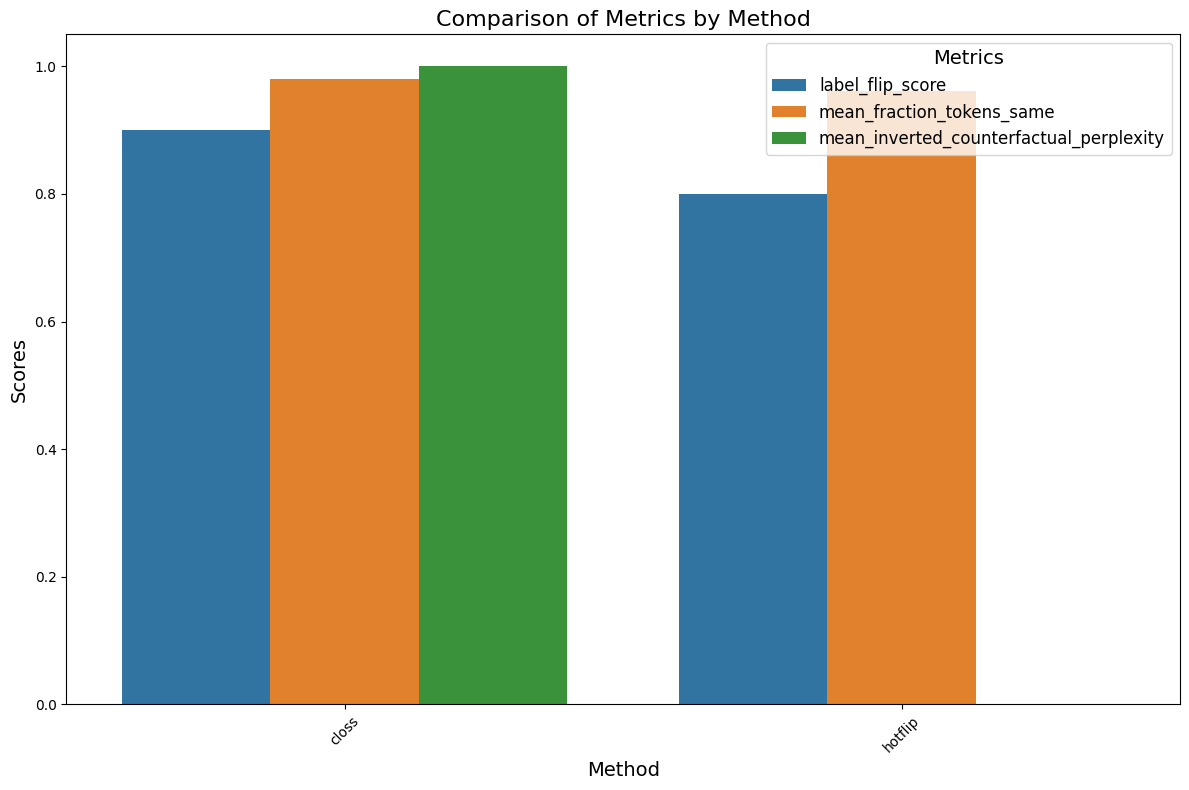

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv("data.csv")

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='method_name', var_name='Metric', value_name='Score')

# Create a grouped bar chart using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='method_name', y='Score', hue='Metric', data=df_melted)

# Customize the plot
plt.title('Comparison of Metrics by Method', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metrics', fontsize=12, title_fontsize=14)
plt.tight_layout()

plt.show()
